In [1]:
%matplotlib inline

In [2]:
import grale.lenses as lenses
import grale.cosmology as cosmology
import grale.images as images
import grale.util as util
from grale.constants import *
import matplotlib.pyplot as plt
import numpy as np

V = lambda x, y: np.array([x,y], dtype=np.double)
cosm = cosmology.Cosmology(0.71, 0.27, 0, 0.73)
cosmology.setDefaultCosmology(cosm)

zd = 0.68
zs1 = 1.734
Ds, Dds = cosm.getAngularDiameterDistance(zs1), cosm.getAngularDiameterDistance(zd, zs1)

In [3]:
lens2 = lenses.GravitationalLens.load("model2/model.lensdata")
img = images.ImagesData.load("model2/src1.imgdata")

# Let's make an input file with only the point with time delay info
ptImg = images.ImagesData(img.getNumberOfImages())
for i in range(img.getNumberOfTimeDelays()):
    imgNum, ptNum, delayDays = img.getTimeDelay(i)
    theta = img.getImagePointPosition(imgNum, ptNum)
    # Now set it in ptImg
    ptNum = ptImg.addPoint(imgNum, theta)
    ptImg.addTimeDelayInfo(imgNum, ptNum, delayDays)
    
del img
# Now, 'ptImg' is the one to use

In [4]:
def getPredictedTimeDelays(lens, img):
    imgPred = util.calculateImagePredictions([{"imgdata": img, "z":  zs1}], lens, cosm)
    imgPred = imgPred[0]
    beta_est = imgPred[0]["beta_est"][0] # Each point has same beta_est

    for i in range(len(imgPred)):
        theta_obs = img.getImagePointPosition(i, 0)
        theta_pred = img.getImagePointPosition(i, 0)
        assert np.array_equal(theta_obs, imgPred[i]["theta_obs"])

        imgNum, ptNum, tdDays = img.getTimeDelay(i) # This is the order in which we've added time delays
        assert imgNum == i and ptNum == 0
        imgPred[i]["delay_obs"] = tdDays if tdDays >= 0 else None # used negative as a signaling mechanism
        imgPred[i]["delay_pred"] = lens.getTimeDelay(zd, Ds, Dds, theta_pred, beta_est)[0]/(60*60*24)

    minTd = min([p["delay_pred"] for p in imgPred])
    for p in imgPred:
        p["delay_pred"] -= minTd
        
    return imgPred

In [5]:
# For the average model:
avgPred = getPredictedTimeDelays(lens2, ptImg)
# To see what this looks like
avgPred

[{'theta_obs': array([ 4.12192470e-05, -5.29547439e-06]),
  'theta_pred': [array([ 4.12201379e-05, -5.29023638e-06])],
  'beta_est': [array([ 1.31692673e-06, -9.41815578e-07])],
  'delay_obs': 781.0,
  'delay_pred': 774.2789216942001},
 {'theta_obs': array([ 3.48342508e-05, -2.24190936e-05]),
  'theta_pred': [array([ 3.48417008e-05, -2.24022846e-05])],
  'beta_est': [array([ 1.31692673e-06, -9.41815578e-07])],
  'delay_obs': 821.6,
  'delay_pred': 814.6961675259736},
 {'theta_obs': array([-5.77897907e-08, -1.03119870e-07]),
  'theta_pred': [array([-5.65471242e-08, -1.00713484e-07])],
  'beta_est': [array([ 1.31692673e-06, -9.41815578e-07])],
  'delay_obs': None,
  'delay_pred': 2693.145142357538},
 {'theta_obs': array([-5.88525023e-06,  2.46417704e-05]),
  'theta_pred': [array([-5.90431230e-06,  2.46390714e-05])],
  'beta_est': [array([ 1.31692673e-06, -9.41815578e-07])],
  'delay_obs': None,
  'delay_pred': 2133.956393244698},
 {'theta_obs': array([-1.86843314e-05, -4.41969241e-05]),


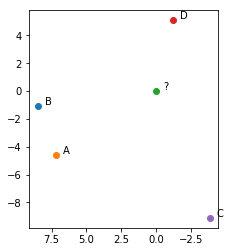

In [6]:
# Map the positions in the array to image names, according to e.g.
# https://ui.adsabs.harvard.edu/abs/2007ApJ...662...62F/abstract

indexMap = { 
    0: 'B', 
    1: 'A', 
    2: '?', 
    3: 'D', 
    4: 'C'}

for i in range(len(avgPred)):
    d = avgPred[i]
    theta = d["theta_obs"]/ANGLE_ARCSEC
    plt.plot([theta[0]], [theta[1]], 'o', label=f"{i}")
    plt.annotate(indexMap[i], theta + V(-.5,.1))
plt.gca().invert_xaxis()
#plt.legend()
plt.gca().set_aspect("equal")

In [7]:
# Get the individual reconstructions on which the average lens is bases
subLenses = [ p["lens"] for p in lens2.getLensParameters() ]

In [8]:
# These are the image point pairs for which we have observations (based on the order above)
delays = { 
    (0,1): [],
    (4,0): [],
    (4,1): []
}
# Calculate the time delay predictions for each sublens and store it
for l in subLenses:
    pred = getPredictedTimeDelays(l, ptImg)
    for key in delays:
        i0, i1 = key
        delays[key].append(pred[i1]["delay_pred"] - pred[i0]["delay_pred"])

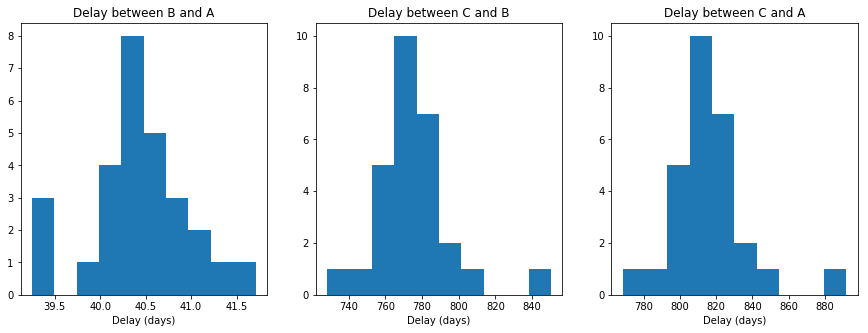

In [9]:
# Create some histograms
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(delays[(0,1)])
plt.title("Delay between " + indexMap[0] + " and " + indexMap[1])
plt.gca().set_xlabel("Delay (days)")
plt.subplot(1,3,2)
plt.hist(delays[(4,0)])
plt.title("Delay between " + indexMap[4] + " and " + indexMap[0])
plt.gca().set_xlabel("Delay (days)")
plt.subplot(1,3,3)
plt.hist(delays[(4,1)])
plt.title("Delay between " + indexMap[4] + " and " + indexMap[1])
plt.gca().set_xlabel("Delay (days)");

In [10]:
for pair in [ (0,1), (4, 0), (4,1) ]:
    pos0 = avgPred[pair[0]]["theta_obs"]/ANGLE_ARCSEC
    pos1 = avgPred[pair[1]]["theta_obs"]/ANGLE_ARCSEC
    print("Time delay between", indexMap[pair[0]], "and", indexMap[pair[1]])
    
    avg, std = np.average(delays[pair]), np.std(delays[pair])
    delayFromAvgModel = avgPred[pair[1]]["delay_pred"] - avgPred[pair[0]]["delay_pred"]
    inputDelay = avgPred[pair[1]]["delay_obs"] - avgPred[pair[0]]["delay_obs"]
    
    print("  Observed delay:          {:.3f}".format(inputDelay))
    print("  Predicted from avg lens: {:.3f}".format(delayFromAvgModel))
    print("  From sublenses:          {:.3f} +/- {:.3f}".format(avg, std))
    print()

Time delay between B and A
  Observed delay:          40.600
  Predicted from avg lens: 40.417
  From sublenses:          40.417 +/- 0.559

Time delay between C and B
  Observed delay:          781.000
  Predicted from avg lens: 774.279
  From sublenses:          774.279 +/- 21.395

Time delay between C and A
  Observed delay:          821.600
  Predicted from avg lens: 814.696
  From sublenses:          814.696 +/- 21.617

